# OCR WITH TESSERACT

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Tesseract overview: https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/33418.pdf

## Install Library

In [3]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 5s (937 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Front

## Import Library

In [4]:
import cv2
import pytesseract
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys, re
np.set_printoptions(threshold=sys.maxsize)

## 1. PREPROCESSING

### 1.1 Convert data to bitmap

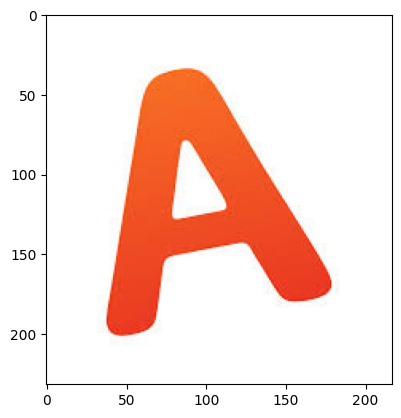

In [5]:
image_path = '/content/drive/MyDrive/Dataset/OCR_data/A.jpeg'
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

### 1.2 Grayscale

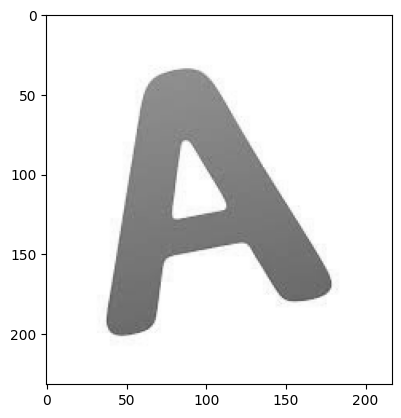

In [6]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

### 1.3 Tresholding

convert to black-and-white

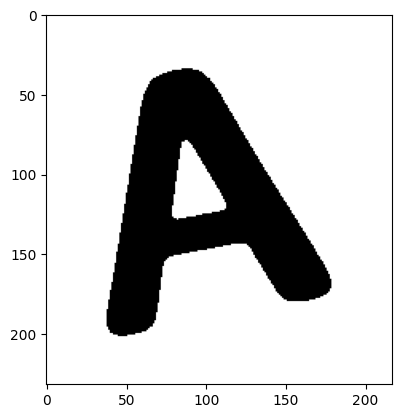

In [7]:
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))

### Check vector from black-and-white image

In [8]:
scale_percent = 8
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
gray_r = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
thresh_r = cv2.threshold(gray_r, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
print(thresh_r)

[[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255   0   0   0 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255   0   0   0   0 255 255 255 255 255 255 255 255]
 [255 255 255 255   0   0   0   0   0   0 255 255 255 255 255 255 255]
 [255 255 255 255   0   0   0   0   0   0 255 255 255 255 255 255 255]
 [255 255 255 255   0   0   0 255   0   0   0 255 255 255 255 255 255]
 [255 255 255 255   0   0 255 255   0   0   0 255 255 255 255 255 255]
 [255 255 255 255   0   0 255 255   0   0   0   0 255 255 255 255 255]
 [255 255 255 255   0   0   0   0   0   0   0   0   0 255 255 255 255]
 [255 255 255   0   0   0   0   0 255 255   0   0   0 255 255 255 255]
 [255 255 255   0   0   0 255 255 255 255 255   0   0   0 255 255 255]
 [255 255 255   0   0   0 255 255 255 255 255   0   0   0 255 255 255]
 [255 

#### Create Function

In [9]:
def preprocessing(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
    plt.show()
    plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
    plt.show()
    return thresh

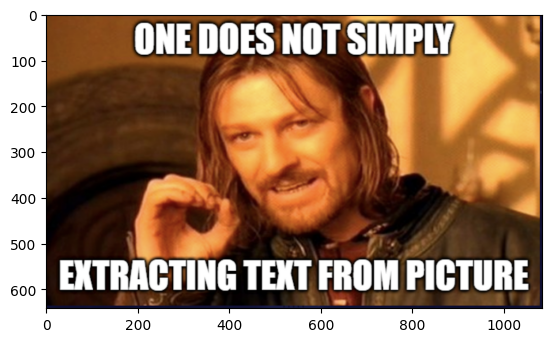

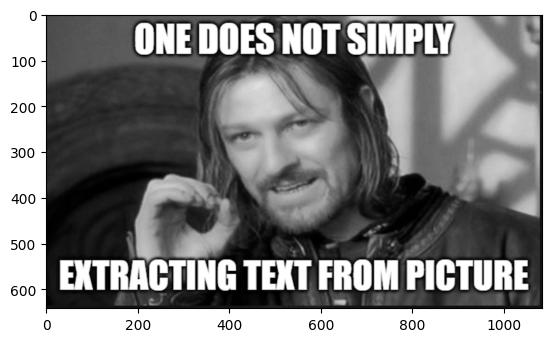

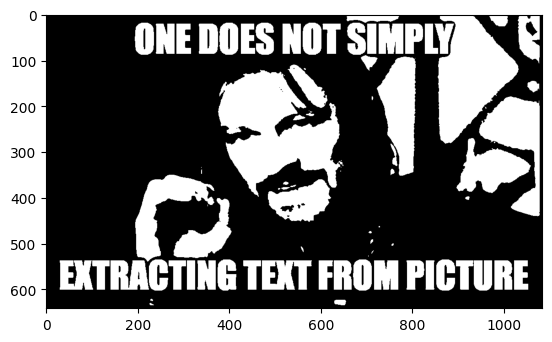

In [10]:
a = preprocessing('/content/drive/MyDrive/Dataset/OCR_data/1_1.png')

## 2. Pytesseract    

### Cutsom Configuration

Page segmentation modes:

0. Orientation and script detection (OSD) only.
1. Automatic page segmentation with OSD.
2. Automatic page segmentation, but no OSD, or OCR. (not implemented)
3. Fully automatic page segmentation, but no OSD. (Default)
4. Assume a single column of text of variable sizes.
5. Assume a single uniform block of vertically aligned text.
6. Assume a single uniform block of text.
7. Treat the image as a single text line.
8. Treat the image as a single word.
9. Treat the image as a single word in a circle.
10. Treat the image as a single character.
11. Sparse text. Find as much text as possible in no particular order.
12. Sparse text with OSD.
13. Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.


OCR Engine modes:

0. Legacy engine only.
1. Neural nets LSTM engine only.
2. Legacy + LSTM engines.
3. Default, based on what is available.

## 2.1 Pytesseract Image to String

In [11]:
def image_to_string(file_path, oem=3, psm=3):
    bnw = preprocessing(file_path)
    custom_config = r"--oem "+str(oem)+" --psm "+str(psm)
    text = pytesseract.image_to_string(bnw, config=custom_config)
    return text

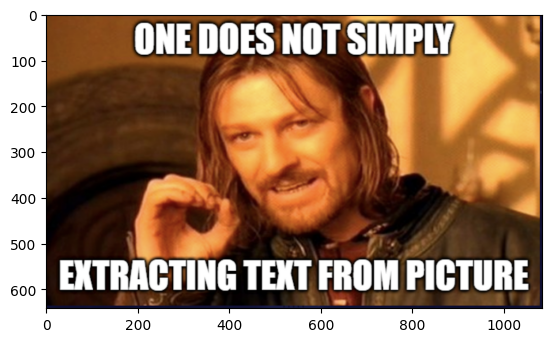

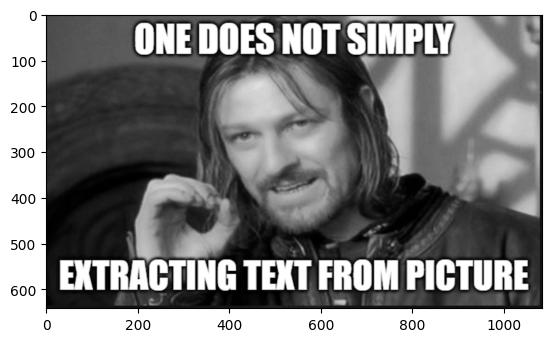

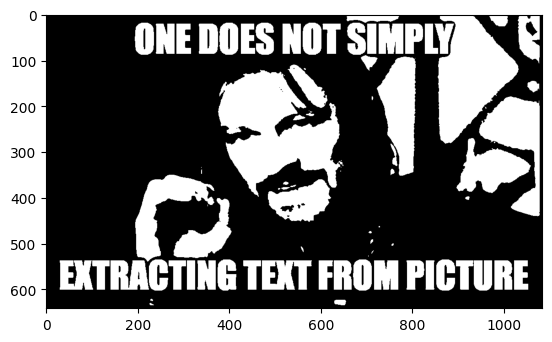

  

ONE DOES NOT SIMPLY, &

Pick

EXTRACTING TEXT FROM PICTURE

  



In [12]:
text = image_to_string('/content/drive/MyDrive/Dataset/OCR_data/1_1.png')
print(text)

## 2.2 Pytesseract Image to Data

In [13]:
def image_to_data(file_path, oem=3, psm=3):
    bnw = preprocessing(file_path)
    custom_config = r"--oem "+str(oem)+" --psm "+str(psm)
    result = pytesseract.image_to_data(bnw, output_type="dict", config=custom_config)
    return result

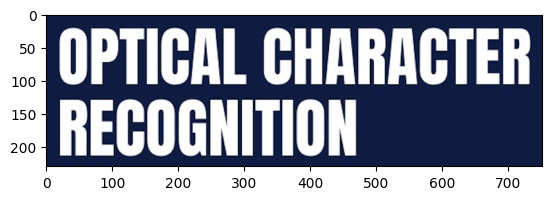

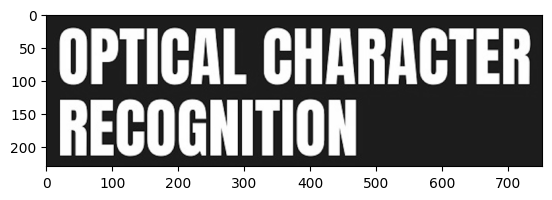

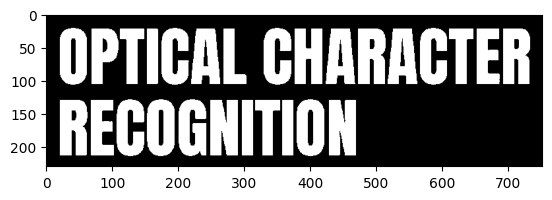

In [14]:
data = image_to_data('/content/drive/MyDrive/Dataset/OCR_data/2_2.png')

In [15]:
data.keys()

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])

# 3. Postprocessing

## 3.1 Simple Postprocessing

In [16]:
def simple_postprocessing(text):
    if text[-1] == '\n':
        text = text[:-1]
        
    text = re.sub('\n\n', '\t', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\t', '\n', text)
    
    return(text)

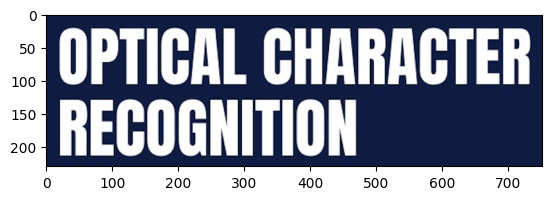

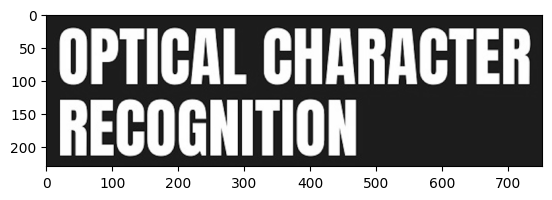

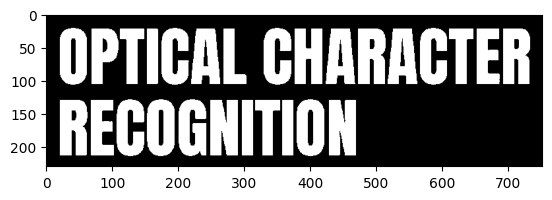

OPTICAL CHARACTER HUE TCU 


In [17]:
ocr_text = image_to_string('/content/drive/MyDrive/Dataset/OCR_data/2_2.png')
result = simple_postprocessing(ocr_text)
print(result)

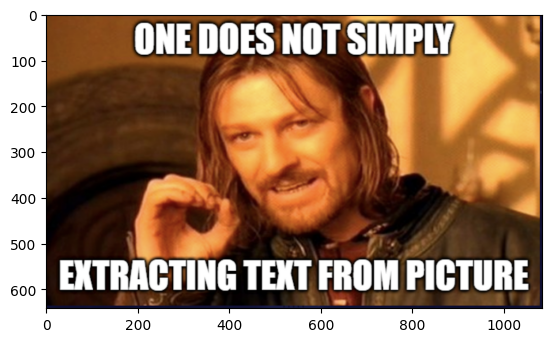

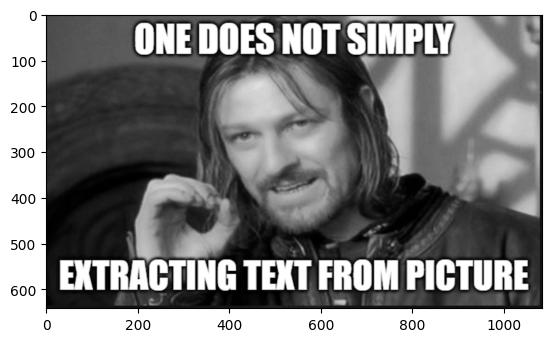

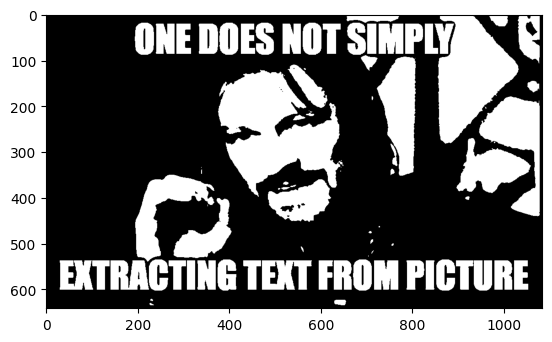

  
ONE DOES NOT SIMPLY, &
Pick
EXTRACTING TEXT FROM PICTURE
   


In [18]:
ocr_text = image_to_string('/content/drive/MyDrive/Dataset/OCR_data/1_1.png')
result = simple_postprocessing(ocr_text)
print(result)

## 3.2 Text Localization

Find text coordinate and create bounding box in original image.

In [19]:
def text_localization(tesseract_results, image_path, confidence_threshold = 50):
    images = cv2.imread(image_path)
    for i in range(0, len(tesseract_results["text"])):

        x = tesseract_results["left"][i]
        y = tesseract_results["top"][i]
        w = tesseract_results["width"][i]
        h = tesseract_results["height"][i]

        text = tesseract_results["text"][i]
        conf = float(tesseract_results["conf"][i])
        
        # filter out weak confidence text localizations
        if conf > confidence_threshold:          
            text = "".join(text).strip()
            cv2.rectangle(images,
                          (x, y),
                          (x + w, y + h),
                          (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(images, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return images

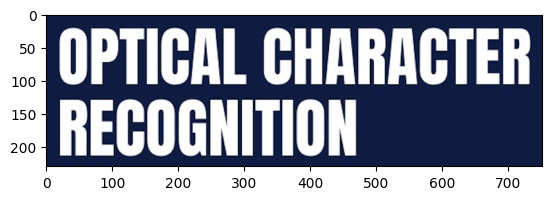

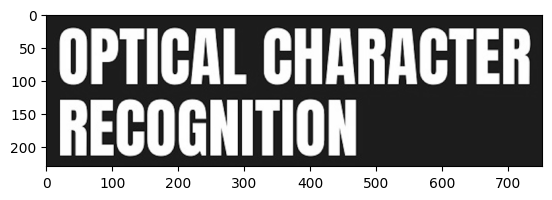

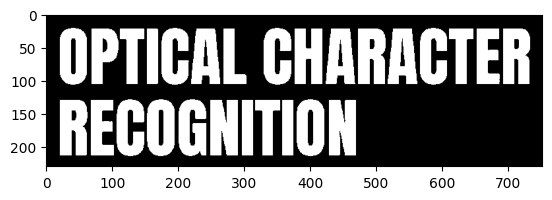

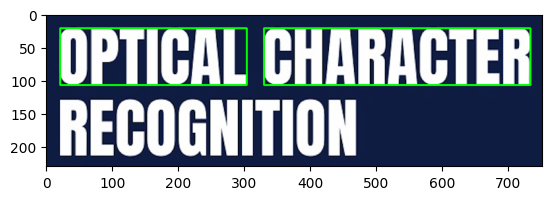

In [20]:
results = image_to_data('/content/drive/MyDrive/Dataset/OCR_data/2_2.png')
bounding_images = text_localization(results, '/content/drive/MyDrive/Dataset/OCR_data/2_2.png', confidence_threshold=50)

# Noisy Image

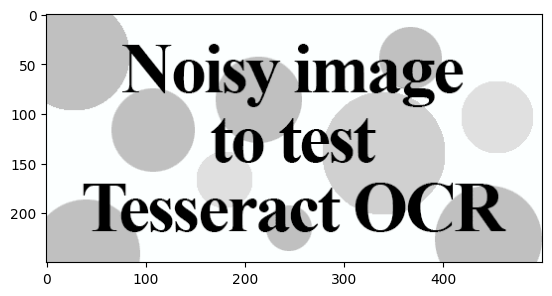

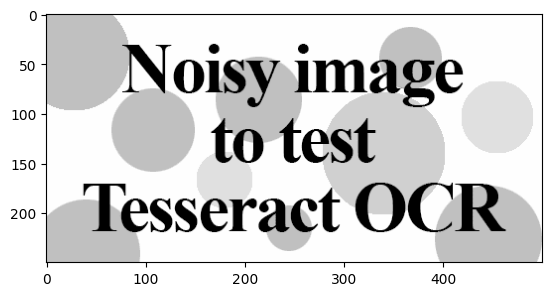

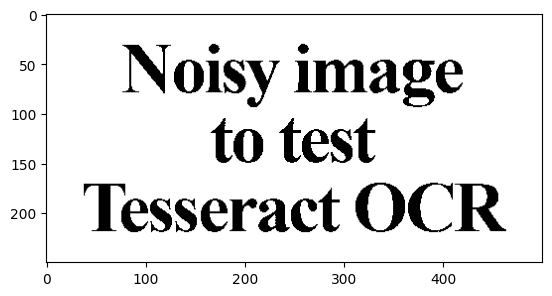

Noisy image to test Tesseract OCR 


In [21]:
text = image_to_string("/content/drive/MyDrive/Dataset/OCR_data/noise_01.jpg")
result = simple_postprocessing(text)
print(result)

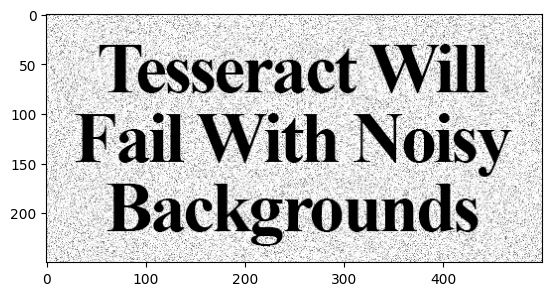

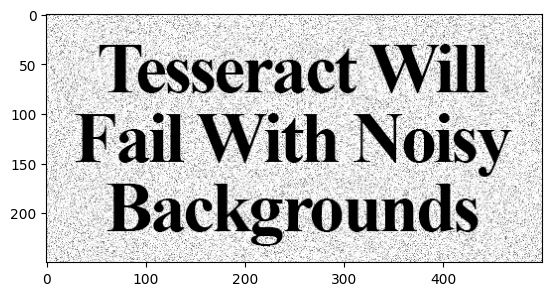

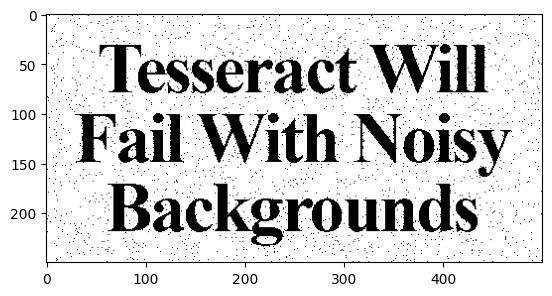

Tesseract Will - Fail With Noisy _ Backgrounds — 


In [22]:
text = image_to_string("/content/drive/MyDrive/Dataset/OCR_data/noise_02.jpg")
result = simple_postprocessing(text)
print(result)

# Handle Simple Table Format

OCR for simple table and save as csv/excel.

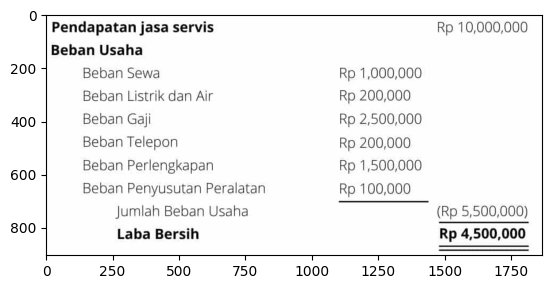

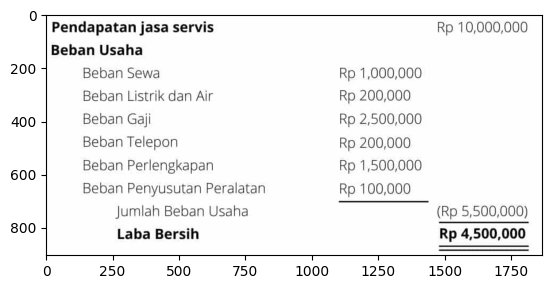

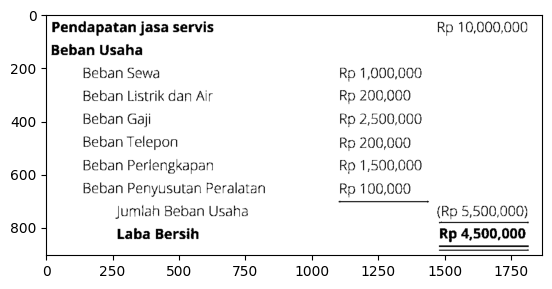

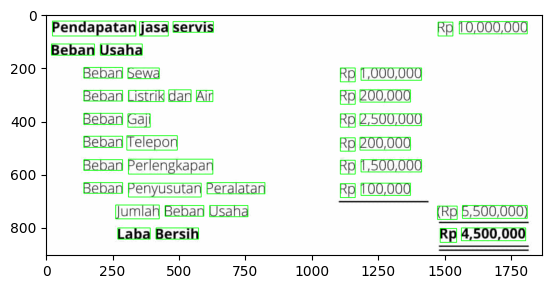

In [26]:
results = image_to_data('/content/drive/MyDrive/Dataset/OCR_data/table.png')
bounding_images = text_localization(results, '/content/drive/MyDrive/Dataset/OCR_data/table.png', confidence_threshold=50)

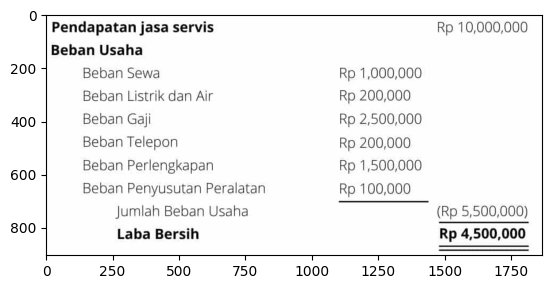

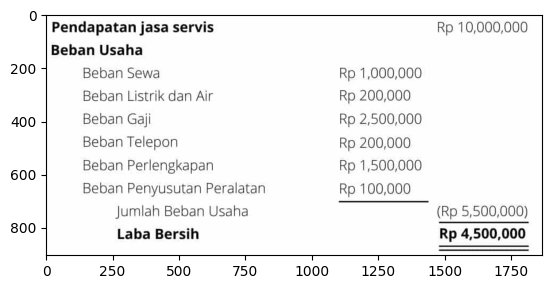

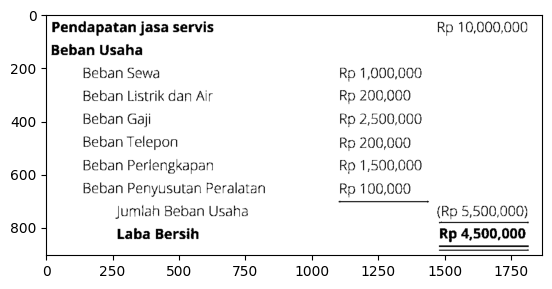

Pendapatan jasa servis
Beban Usaha

Beban Sewa

Beban Listrik dan Air

Beban Gaji

Beban Telepon

Beban Periengkapan

Beban Penyusutan Peralatan
Jumlah Beban Usaha
Laba Bersih

Rp 10,000,000

Rp 1,000,000
Rp 200,000
Rp 2,500,000
Rp 200,000
Rp 1,500,000

Rp 100,000

(Rp 5,500,000)
Rp 4,500,000



In [28]:
a = image_to_string('/content/drive/MyDrive/Dataset/OCR_data/table.png')
print(a)

In [29]:
results.keys()

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])

#### Image to data have coordinate for each words, use block_num and line_num to get each entry for each tabel and column.

In [30]:

def simple_table(results, threshold_gap = 400, confidence_threshold=70):
    result_list = []
    uni_par = np.unique(results['block_num'])
    for i, pn in enumerate(uni_par):

        par_index = np.where(np.array(results['block_num']) == pn)[0]
        par_text = np.array(results['text'])[par_index]
        par_left = np.array(results['left'])[par_index]
        par_width = np.array(results['width'])[par_index]
        par_conf = np.array(results['conf'])[par_index]
        par_line = np.array(results['line_num'])[par_index]

        uni_line = np.unique(par_line)
        for j, ln in enumerate(uni_line):
            temp_result = []

            line_index = np.where(par_line == ln)[0]
            line_text = par_text[line_index]
            line_left = par_left[line_index]
            line_width = par_line[line_index]
            line_conf = par_conf[line_index]

            temp_result.append([])
            k = 0
            while k < len(line_text)-1:
                if line_text[k] != '' and line_text[k+1] != '':

                    end_k = line_left[k]+line_width[k]
                    
                    if float(line_conf[k]) > confidence_threshold:
                        temp_result[-1].append(line_text[k])

                    if (line_left[k+1] - end_k) > threshold_gap and temp_result[-1] != []:
                        temp_result.append([])

                k += 1
            temp_result[-1].append(line_text[k])

            temp_result = [' '.join(tp) for tp in temp_result]

            if temp_result != [''] and temp_result != [' ']:
                result_list.append(temp_result)

    df = pd.DataFrame(result_list)  
    return df
                

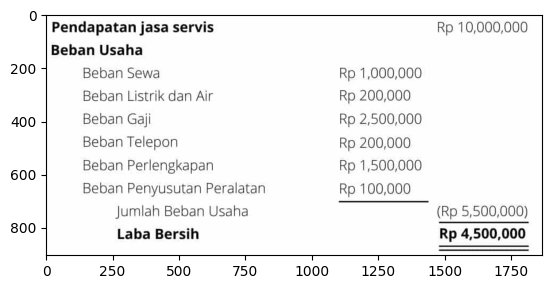

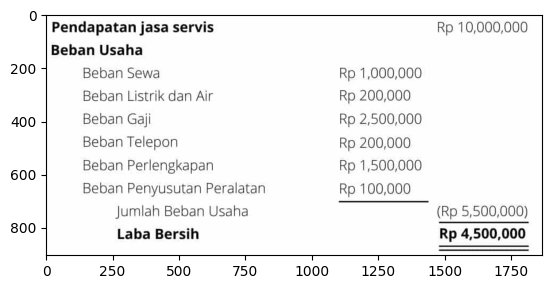

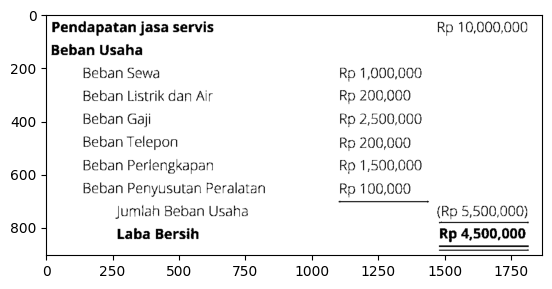

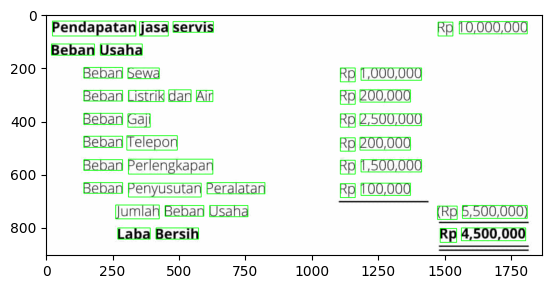

0
0                              Pendapatan jasa servis
1                                         Beban Usaha
2   Beban Beban Listrik dan Beban Beban Beban Beba...
3                                  Jumlah Beban Usaha
4                                         Laba Bersih
5                                       Rp 10,000,000
6                                        Rp 1,000,000
7                                          Rp 200,000
8                                        Rp 2,500,000
9                                          Rp 200,000
10                                       Rp 1,500,000
11                                         Rp 100,000
12                                     (Rp 5,500,000)
13                                       Rp 4,500,000

In [31]:
image_path = '/content/drive/MyDrive/Dataset/OCR_data/table.png'
results = image_to_data(image_path)
bounding_images = text_localization(results, image_path, confidence_threshold=70)
df = simple_table(results, threshold_gap=400, confidence_threshold=70)
df

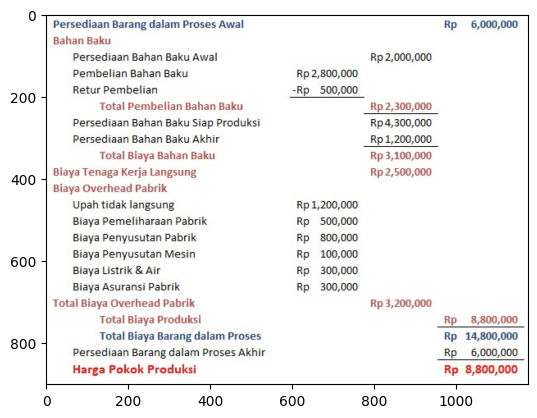

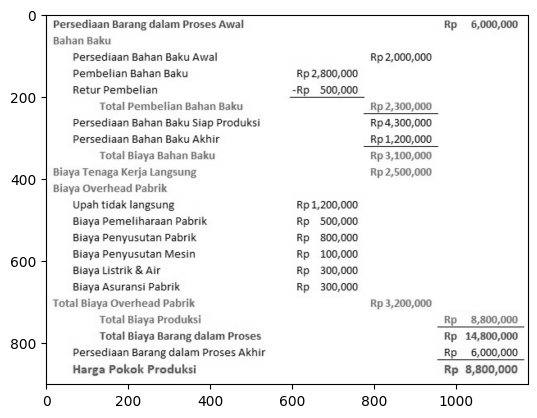

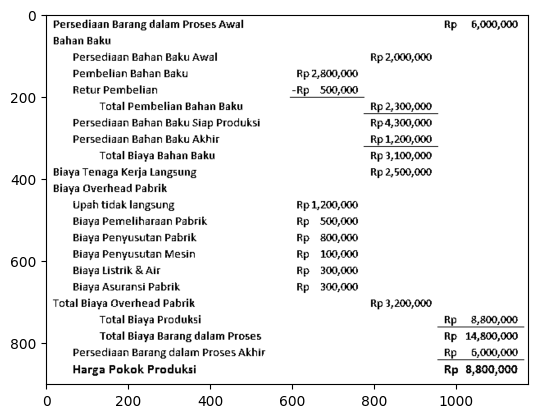

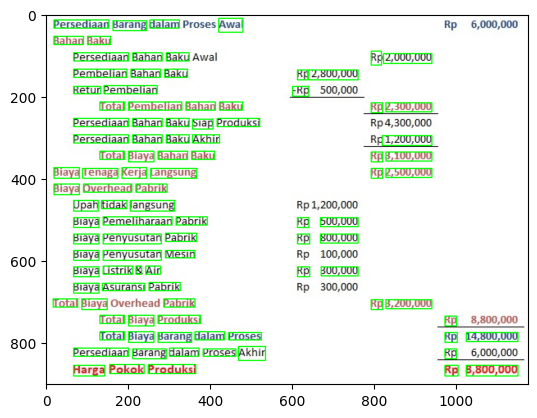

0              1
0                    Persediaan Barang dalam Awal      6,000,000
1                                      Bahan Baku           None
2                           Persediaan Bahan Baku  Rep 2,000,000
3               Pembelian Bahan Baku Re 2,800,000           None
4                                 Retur Pembelian    -Rp 500,000
5         Total Pembelian Bahan Baku Rp 2,300,000           None
6   Persediaan Bahan Baku Siap Produksi 4,300,000           None
7                     Persediaan Bahan Baku Akhir      1,200,000
8                          Total Biaya Bahan Baku   Rp 3,100,000
9                     Biaya Tenaga Kerja Langsung   Rp 2,500,000
10                          Biaya Overhead Pabrik           None
11                  Upah tidak langsung 1,200,000           None
12           Biaya Pemeliharaan Pabrik Rp 500,000           None
13             Biaya Penyusutan Pabrik Re 800,000           None
14                 Biaya Penyusutan Mesin 100,000           None
15                 Biaya Listrik & Air Re 300,000           None
16                  Biaya Asuransi Pabrik 300,000           None
17                             Total Biaya Pabrik   Rp 3,200,000
18                           Total Biaya Produksi   Rp 8,800,000
19                Total Biaya Barang dalam Proses  Rp 14,800,000
20           Persediaan Barang dalam Proses Akhir   Rp 6,000,000
21                           Harga Pokok Produksi   Rp 8,800,000

In [32]:
image_path = '/content/drive/MyDrive/Dataset/OCR_data/table2.png'
results = image_to_data(image_path)
bounding_images = text_localization(results, image_path, confidence_threshold=70)
df = simple_table(results, threshold_gap=400, confidence_threshold=70)
df

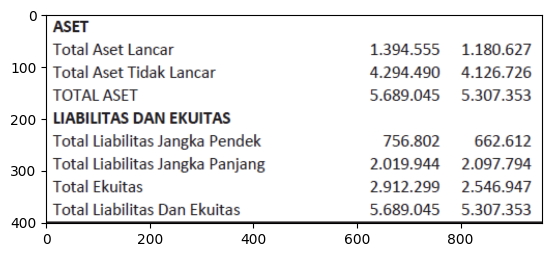

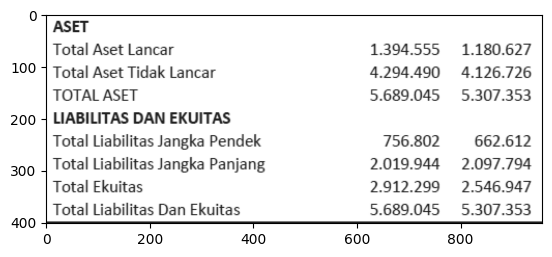

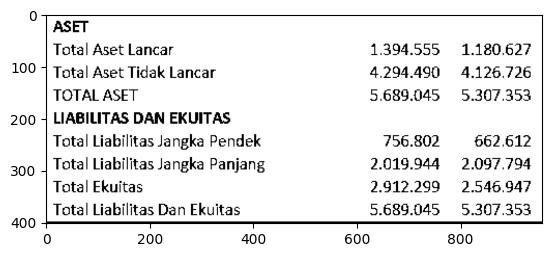

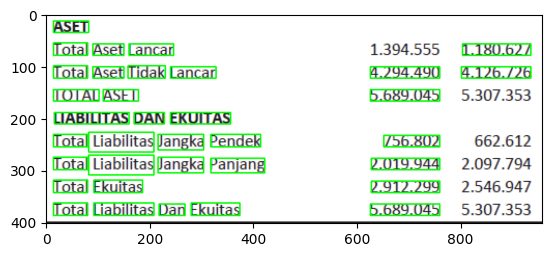

0
0   Total Aset Total Aset Tidak LIABILITAS DAN Tot...
1                TOTAL Total Liabilitas Jangka Pendek
2                     Total Liabilitas Jangka Panjang
3                                       Total Ekuitas
4                                           1.394.555
5                                           4.294.490
6                                           5.689.045
7                                             756.802
8                                           2.019.944
9                                           2.912.299
10                                          5.689.045
11                                          1.180.627
12                                          4.126.726
13                                          9.307.353
14                                            662.612
15                                          2.097.794
16                                          2.546.947
17                                          9.307.353

In [33]:
image_path = '/content/drive/MyDrive/Dataset/OCR_data/table6.png'
results = image_to_data(image_path)
bounding_images = text_localization(results, image_path, confidence_threshold=70)
df = simple_table(results, threshold_gap=400, confidence_threshold=70)
df

#### simple_table function fail to parse table6.png, try another method
#### use coordinate from tesseract result instead of block and line number

In [34]:
def simple_table2(results, threshold_gap = 20, confidence_threshold=70):
    text_list = []
    top_list = []
    left_list = []
    width_list = []
    conf_list = []

    for i, text in enumerate(results['text']):
        if text != '' and text != ' ':
            top = results['top'][i]
            if top_list == []:
                top_list.append(top)
                text_list.append([])
                left_list.append([])
                width_list.append([])
                conf_list.append([])

            min_dist = [1 if np.absolute(tl-top) < 10 else 0 for tl in top_list]
            unique = np.unique(min_dist)
            if len(unique) == 1 and unique == 0:
                top_list.append(top)
                text_list.append([])
                left_list.append([])
                width_list.append([])
                conf_list.append([])
                top_index = len(top_list)-1
            else:
                top_index = min_dist.index(1)


            text_list[top_index].append(text)
            left_list[top_index].append(results['left'][i])
            width_list[top_index].append(results['width'][i])
            conf_list[top_index].append(results['conf'][i])


    result_list = []
    for i, line_text in enumerate(text_list):

        line_width = width_list[i]
        line_left = left_list[i]
        line_conf = conf_list[i]
        temp_result = [[]]
        k = 0
        while k < len(line_text)-1:
            if line_text[k] != '' and line_text[k+1] != '':

                end_k = line_left[k]+line_width[k]

                if float(line_conf[k]) > confidence_threshold:
                    temp_result[-1].append(line_text[k])

                if (line_left[k+1] - end_k) > threshold_gap and temp_result[-1] != []:
                    temp_result.append([])

            k += 1
        temp_result[-1].append(line_text[k])

        temp_result = [' '.join(tp) for tp in temp_result]

        if temp_result != [''] and temp_result != [' ']:
            result_list.append(temp_result)

    df = pd.DataFrame(result_list)  
    return df
        
    

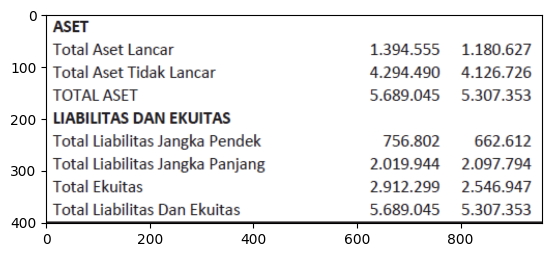

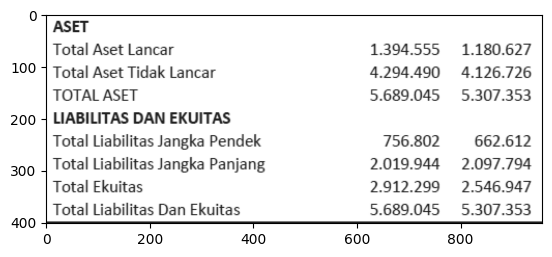

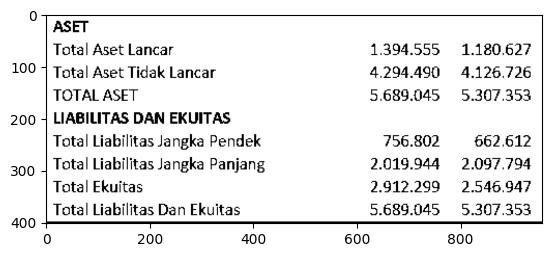

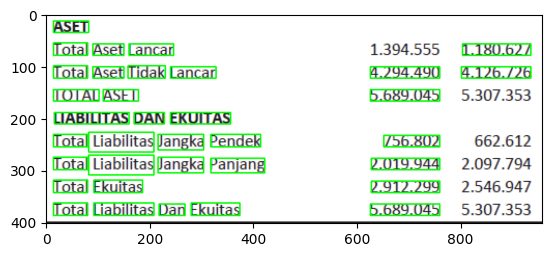

0          1          2
0                             ASET       None       None
1                Total Aset Lancar  1.180.627       None
2          Total Aset Tidak Lancar  4.294.490  4.126.726
3                       TOTAL ASET  5.689.045  9.307.353
4           LIABILITAS DAN EKUITAS       None       None
5   Total Liabilitas Jangka Pendek    756.802    662.612
6  Total Liabilitas Jangka Panjang  2.019.944  2.097.794
7                    Total Ekuitas  2.912.299  2.546.947
8     Total Liabilitas Dan Ekuitas  5.689.045  9.307.353

In [35]:
image_path = '/content/drive/MyDrive/Dataset/OCR_data/table6.png'
results = image_to_data(image_path)
bounding_images = text_localization(results, image_path, confidence_threshold=70)
df = simple_table2(results, threshold_gap=20, confidence_threshold=70)
df

In [38]:
df.to_csv('table.csv', index=None)

# Extract text in any box

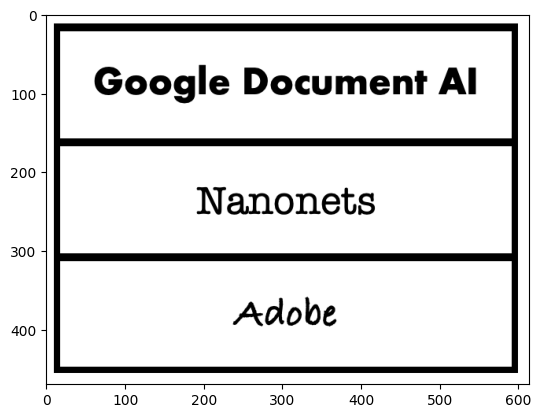

In [39]:
image = cv2.imread("/content/drive/MyDrive/Dataset/OCR_data/boxes.png")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Box detection

In [40]:
''' source https://pyimagesearch.com/2015/04/20/sorting-contours-using-python-and-opencv/'''

def sort_contours(cnts, method="left-to-right"):
    
    reverse = False
    i = 0

    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    return (cnts, boundingBoxes)


#### Simple box detection using opencv.

In [44]:
image = cv2.imread("/content/drive/MyDrive/Dataset/OCR_data/boxes2.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray,128,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1]

H, W, C = image.shape
cropped_dir_path = 'crop_image/'

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
(contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")

idx = 0
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w > 50 and h > 50) and w >= 2.5*h:
        if h < 0.9*H:
            idx += 1
            new_img = image[y:y+h, x:x+w]
            cv2.imwrite(cropped_dir_path+str(idx) + '.png', new_img)
        
    if (w > 50 and h > 50) and w < 2.5*h and w >= h:
        if w < 0.9*W and h < 0.9*H:
            idx += 1
            new_img = image[y:y+h, x:x+w]
            cv2.imwrite(cropped_dir_path+str(idx) + '.png', new_img)

#### For more advance box detection, try using cv2.getStructuringElement, cv2.HoughLinesP, etc.

for example: https://levelup.gitconnected.com/text-extraction-from-a-table-image-using-pytesseract-and-opencv-3342870691ae

## Detect Text in Each Box

In [43]:
image = cv2.imread("/content/drive/MyDrive/Dataset/OCR_data/boxes2.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray,128,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1]

H, W, C = image.shape
custom_config = r"--oem 3 --psm 3"

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
(contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")

idx = 0
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w > 50 and h > 50) and w >= 2.5*h:
        if h < 0.9*H:
            idx += 1
            new_thresh = thresh[y:y+h, x:x+w]
            text = pytesseract.image_to_string(new_thresh, config=custom_config)
            print(simple_postprocessing(text))
        
    if (w > 50 and h > 50) and w < 2.5*h and w >= h:
        if w < 0.9*W and h < 0.9*H:
            idx += 1
            new_thresh = thresh[y:y+h, x:x+w]
            text = pytesseract.image_to_string(new_thresh, config=custom_config)
            print(simple_postprocessing(text))

https://cloud.google.com/document-ai/docs/drag-and-drop 
Google Document Al 
https://nanonets.com/blog/ocr-with-tesseract/ 
Nanonets 
https://experienceleague.adobe.com/docs/document-cloud- learn/acrobat-learning/getting-started/scan-and-ocr.html?lang=en 
Adobe 


# Handle PDF Data

In [48]:
!apt-get install poppler-utils 
!pip install pdf2image

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 174 kB of archives.
After this operation, 754 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 poppler-utils amd64 0.86.1-0ubuntu1.1 [174 kB]
Fetched 174 kB in 31s (5,699 B/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 122592 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.86.1-0ubuntu1.1_amd64.deb ...
Unpacking poppler-utils (0.86.1-0ubuntu1.1) ...
Setting up poppler-utils (0.86.1-0ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
from pdf2image import convert_from_path

doc = convert_from_path('/content/drive/MyDrive/Dataset/OCR_data/table.pdf')

for page_number, page_data in enumerate(doc):
    image = np.array(page_data)

# Handwriting Recognition

data: https://www.kaggle.com/datasets/landlord/handwriting-recognition

some code for handwriting recognition : https://www.kaggle.com/datasets/landlord/handwriting-recognition/code